In [1]:
from network import Transformer, TransformerModel
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [2]:
def get_cosine_data():
    t_vals = np.linspace(0, 1000, 1000)
    return np.vstack((t_vals, np.cos(1/60 * t_vals) * t_vals / 50)).T

points = get_cosine_data()
points

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.00100100e+00,  2.00172340e-02],
       [ 2.00200200e+00,  4.00177531e-02],
       ...,
       [ 9.97997998e+02, -1.20072266e+01],
       [ 9.98998999e+02, -1.17513354e+01],
       [ 1.00000000e+03, -1.14916334e+01]])

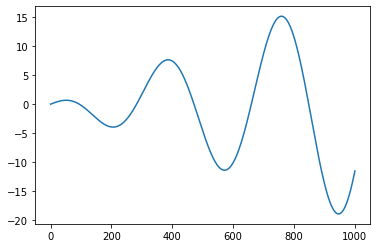

In [3]:
plt.plot(points[:,0], points[:,1])

In [154]:
def get_random_sequence(data, in_seq_len, out_seq_len):
    data_start_index = np.random.randint(0, data.shape[0] - in_seq_len - out_seq_len + 1)
    in_seq, out_seq = data[data_start_index:data_start_index+in_seq_len].copy(), data[data_start_index+in_seq_len-1:data_start_index+in_seq_len+out_seq_len].copy()
    right_most = in_seq[-1].copy()
    in_seq -= right_most
    out_seq -= right_most
    in_seq[:, 0] /= 6
    out_seq[:, 0] /= 6
    in_seq[:, 1] /= 20
    out_seq[:, 1] /= 20
    return in_seq, out_seq[:-1], out_seq[1:]

def get_random_batch(data, in_seq_len, out_seq_len, batch_size):
    in_seq_dat, out_seq_dat, label_seq_dat = [], [], []
    for _ in range(batch_size):
        in_cur, out_cur, label_cur = get_random_sequence(data, in_seq_len, out_seq_len)
        in_seq_dat.append(in_cur)
        out_seq_dat.append(out_cur)
        label_seq_dat.append(label_cur)
    return np.array(in_seq_dat), np.array(out_seq_dat), np.array(label_seq_dat)


In [155]:
get_random_sequence(points.copy(), 4, 6)

(array([[-0.5005005 , -0.00944241],
        [-0.333667  , -0.00621648],
        [-0.1668335 , -0.00306855],
        [ 0.        ,  0.        ]]),
 array([[0.        , 0.        ],
        [0.1668335 , 0.00298779],
        [0.333667  , 0.00589346],
        [0.5005005 , 0.00871568],
        [0.667334  , 0.01145314],
        [0.8341675 , 0.01410454]]),
 array([[0.1668335 , 0.00298779],
        [0.333667  , 0.00589346],
        [0.5005005 , 0.00871568],
        [0.667334  , 0.01145314],
        [0.8341675 , 0.01410454],
        [1.001001  , 0.01666861]]))

In [156]:
batch_in, batch_out, batch_label = get_random_batch(points.copy(), 4, 6, 5)
batch_in, batch_out, batch_label
batch_label

array([[[ 1.66833500e-01, -4.05892290e-03],
        [ 3.33667000e-01, -8.22623433e-03],
        [ 5.00500501e-01, -1.25011762e-02],
        [ 6.67334001e-01, -1.68829538e-02],
        [ 8.34167501e-01, -2.13707364e-02],
        [ 1.00100100e+00, -2.59636567e-02]],

       [[ 1.66833500e-01,  4.89415766e-03],
        [ 3.33667000e-01,  9.81274835e-03],
        [ 5.00500501e-01,  1.47543378e-02],
        [ 6.67334001e-01,  1.97174762e-02],
        [ 8.34167501e-01,  2.47006983e-02],
        [ 1.00100100e+00,  2.97025243e-02]],

       [[ 1.66833500e-01,  5.87206962e-04],
        [ 3.33667000e-01,  1.06610732e-03],
        [ 5.00500501e-01,  1.43601245e-03],
        [ 6.67334001e-01,  1.69626488e-03],
        [ 8.34167501e-01,  1.84623866e-03],
        [ 1.00100100e+00,  1.88533966e-03]],

       [[ 1.66833500e-01, -1.37709707e-03],
        [ 3.33667000e-01, -2.78959860e-03],
        [ 5.00500501e-01, -4.23715468e-03],
        [ 6.67334001e-01, -5.71939635e-03],
        [ 8.34167501e-01, 

In [157]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
#X, y_in, y_label = get_random_batch(points.copy(), 4, 6, 1)
#X, y_in, y_label = torch.tensor(X).float().to(device), torch.tensor(y_in).float().to(device), torch.tensor(y_label).float().to(device)
#X /= X.std(axis=1)
#y /= y.std(axis=1)
#print(X.std(axis=1))
def train_loop(model, opt, loss_fn, num_batches, batch_size, device):
    model.train()
    total_loss = 0
    
    for _ in range(num_batches):
        #X, y = get_random_batch(points.copy(), 4, 6, batch_size)
        #X, y = torch.tensor(X).float().to(device), torch.tensor(y).float().to(device)
        X, y_in, y_label = get_random_batch(points.copy(), 4, 6, batch_size)
        X, y_in, y_label = torch.tensor(X).float().to(device), torch.tensor(y_in).float().to(device), torch.tensor(y_label).float().to(device)
        
        # Get mask to mask out the next words
        sequence_length = y_in.size(1)
        tgt_mask = model.generate_square_subsequent_mask(sequence_length).to(device).float()

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_in, tgt_mask)
        # Permute pred to have batch size first again
        pred = pred.permute(1, 0, 2) 
        loss = loss_fn(pred, y_label)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / num_batches

def fit(model, opt, loss_fn, num_batches, batch_size, epochs, device):
    
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training model")
    for epoch in range(epochs):
        if epoch % 10 == 9:
            print("-"*25, f"Epoch {epoch + 1}","-"*25)
            
            train_loss = train_loop(model, opt, loss_fn, num_batches, batch_size, device)
            train_loss_list += [train_loss]
            
            print(f"Training loss: {train_loss:.4f}")
            print()
        
    return train_loss_list, validation_loss_list

cuda


In [158]:

model = Transformer(dim_model=16,
                    dim_feature=2,
                    num_heads=8,
                    num_encoder_layers=1,
                    num_decoder_layers=1,
                    dropout_p=0.00).to(device)


#model = TransformerModel(
#    d_model=8,
#    d_encoder_in=2,
#    d_decoder_out=2,
#    nhead=4,
#    d_hid=128,
#    nlayers=6,
#).to(device)

loss_fn = nn.MSELoss()

In [159]:
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
fit(model, opt, loss_fn, 1024, 32, 20, device)

Training and validating model
------------------------- Epoch 10 -------------------------
Training loss: 0.0062

------------------------- Epoch 20 -------------------------
Training loss: 0.0000



([0.006243685925627851, 1.957722891121616e-05], [])

In [165]:
X, y_in, y_label = get_random_batch(points.copy(), 4, 6, 1)
X, y_in, y_label = torch.tensor(X).float().to(device), torch.tensor(y_in).float().to(device), torch.tensor(y_label).float().to(device)
X_loc, y_label_loc = X.cpu(), y_label.cpu()
y_loc = y_label_loc.permute(1, 0, 2)
X_loc, y_loc

(tensor([[[-0.5005,  0.0180],
          [-0.3337,  0.0118],
          [-0.1668,  0.0058],
          [ 0.0000,  0.0000]]]),
 tensor([[[ 0.1668, -0.0055]],
 
         [[ 0.3337, -0.0108]],
 
         [[ 0.5005, -0.0159]],
 
         [[ 0.6673, -0.0207]],
 
         [[ 0.8342, -0.0252]],
 
         [[ 1.0010, -0.0296]]]))

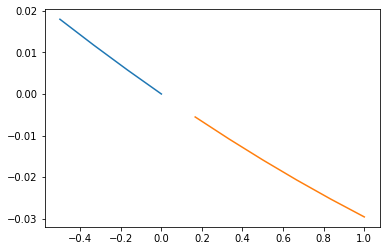

In [166]:
plt.plot(X_loc[0,:,0], X_loc[0,:, 1])
plt.plot(y_loc[:,0,0], y_loc[:,0, 1])

In [167]:
tgt_mask = model.generate_square_subsequent_mask(6).to(device).float()
out = model(X, y_in, tgt_mask)#.permute(1, 0, 2)
out_cpu = out.cpu().detach()
out_cpu

tensor([[[ 0.1701, -0.0054]],

        [[ 0.3357, -0.0115]],

        [[ 0.5009, -0.0163]],

        [[ 0.6687, -0.0219]],

        [[ 0.8350, -0.0278]],

        [[ 1.0033, -0.0319]]])

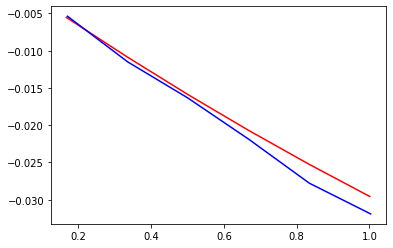

In [168]:
plt.plot(y_loc[:,0,0], y_loc[:,0, 1],color="red")
plt.plot(out_cpu[:,0,0], out_cpu[:,0, 1],color="blue")

In [164]:
def predict(model, input_sequence, output_sequence_length):
    model.eval()
    START_TOKEN = input_sequence[0, -1]
    y_input = START_TOKEN[None,None,:]
    for _ in range(output_sequence_length):
        # Get source mask
        tgt_mask = model.generate_square_subsequent_mask(y_input.size(1)).to(device)
        
        pred = model(input_sequence, y_input, tgt_mask)
        pred = pred.permute(1, 0, 2)
        next_item = pred[0, -1][None, None, :]

        # Concatenate previous input with predicted best word
        y_input = torch.cat((y_input, next_item), dim=1)
    return y_input[0,1:]

def predict_multi(model, start_sequence, output_sequence_length, num_predictions):
    current_input = start_sequence
    outputs = predict(model, current_input, output_sequence_length)
    current_input = outputs[None, :, :].clone()
    last_mean = torch.mean(current_input, axis=1)
    total_mean = last_mean
    current_input -= last_mean
    for _ in range(num_predictions - 1):
        output = predict(model, current_input, output_sequence_length)
        outputs = torch.cat((outputs, output + outputs[-1]), dim=0)
        current_input = output[None, :, :].clone()
        last_mean = torch.mean(current_input, axis=1)
        current_input -= last_mean
    return outputs


In [142]:
predicted_points = predict_multi(model, X, 6, 100).cpu().detach()
predicted_points

tensor([[ 1.6864e-01, -4.9596e-03],
        [ 3.3760e-01, -9.3854e-03],
        [ 5.0750e-01, -1.4819e-02],
        ...,
        [ 1.0703e+02, -8.7663e+00],
        [ 1.0713e+02, -8.7706e+00],
        [ 1.0715e+02, -8.7671e+00]])

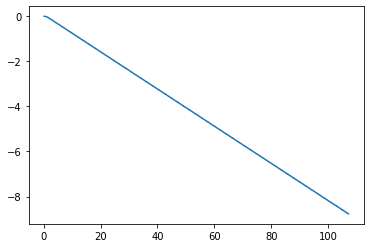

In [143]:
plt.plot(predicted_points[:, 0], predicted_points[:, 1])